# Logit Lens and Direct Logit Attribution

In this notebook we explore how the model is doing prediction of the first path token in the maze (ie. the token that immediately comes after the `PATH_START` token), to this end we use:

* Logit Lens
* Direct Logit Attribution
* Activation Patching

In summary, we find that the majority of computation associated with this task is in the form of MLP computation (in particular in MLP10 and MLP11) but that there does appear to be a few heads within early layers (Layer 0, 1 and 2) that are also playing some role. Further evals outside of this notebook however are suggestive of this instance of maze-transformer doing some form of memorization (atleast overfitting to its training data and not generalising OOD), for this reason, this study has not yet been taken further.

This notebook takes significant inspiration from two great resources:

* Nanda's [Exploratory Analysis Demo](https://github.com/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb) Notebook
* Janiak & Heimersheim's [Python docstrings](https://colab.research.google.com/drive/17CoA1yARaWHvV14zQGcI3ISz1bIRZKS5) Notebook

# Setup

In [1]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt

from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
# TransformerLens imports
from transformer_lens import ActivationCache

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP

# model stuff
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig

# mechinterp stuff
from maze_transformer.mechinterp.plot_logits import plot_logits
from maze_transformer.mechinterp.logit_attrib_task import DLAProtocol, DLAProtocolFixed, token_after_fixed_start_token, LOGIT_ATTRIB_TASKS
from maze_transformer.mechinterp.logit_diff import logits_diff_multi
from maze_transformer.mechinterp.logit_lens import plot_logit_lens
from maze_transformer.mechinterp.direct_logit_attribution import plot_direct_logit_attribution
from maze_transformer.mechinterp.plot_attention import plot_attention_final_token



c:\Users\mivan\AppData\Local\pypoetry\Cache\virtualenvs\maze-transformer-2cGx2R0F-py3.10\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)

# print the available logit attribution tasks
print(f"{list(LOGIT_ATTRIB_TASKS.keys()) = }")

DEVICE = device(type='cpu')
list(LOGIT_ATTRIB_TASKS.keys()) = ['path_start', 'origin_after_path_start', 'first_path_choice', 'path_end', 'final_before_path_end', 'rand_path_token', 'rand_path_token_non_endpoint']


## primary configuration

this is where we pick the model to load, task to perform, dataset to use, etc

In [3]:
# path to load the model from
MODEL_PATH: str = "../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj"
# source for dataset config. Either add your own here, or it will copy the one from the model if set to None
DATASET_CFG_SOURCE: MazeDatasetConfig|None = None
# number of examples to run experiments on
N_EXAMPLES: int = 100
# task to perform
LOGIT_ATTRIBUTION_TASK_NAME: str = "origin_after_path_start"
# if you have a custom task, set it here -- otherwise we will attempt to load one of the known tasks
LOGIT_ATTRIBUTION_TASK: DLAProtocolFixed|None = None
if LOGIT_ATTRIBUTION_TASK is None:
    LOGIT_ATTRIBUTION_TASK = LOGIT_ATTRIB_TASKS[LOGIT_ATTRIBUTION_TASK_NAME]

## Loading the model in

By default, we load the small "hallway" model

In [4]:
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
num_params: int = MODEL.num_params()
print(f"loaded model with {shorten_numerical_to_str(num_params)} params ({num_params = }) from\n{MODEL_PATH}")
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer

loaded model with 1.3M params (num_params = 1274699) from
../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj


## Dataset Creation

Creating a collection of mazes to have the model predict on

In [5]:
# copy config if needed, adjust number of mazes
if DATASET_CFG_SOURCE is None:
	DATASET_CFG_SOURCE = deepcopy(MODEL.zanj_model_config.dataset_cfg)
DATASET_CFG_SOURCE.n_mazes = N_EXAMPLES

# get the dataset and tokens
DATASET: MazeDataset = MazeDataset.from_config(DATASET_CFG_SOURCE)
DATASET_TOKENS: list[list[str]] = DATASET.as_tokens(TOKENIZER, join_tokens_individual_maze=False)

# print some info
print(f"loaded {len(DATASET_TOKENS)} mazes")
print(f"first maze:\n{' '.join(DATASET_TOKENS[0])}")
print(f"first maze, colored:\n{color_maze_tokens_AOTP(DATASET_TOKENS[0], fmt='terminal')}")

loaded 100 mazes
first maze:
<ADJLIST_START> (6,4) <--> (6,3) ; (4,7) <--> (3,7) ; (3,4) <--> (3,5) ; (3,3) <--> (4,3) ; (4,4) <--> (4,5) ; (3,7) <--> (3,6) ; (3,3) <--> (3,4) ; (4,7) <--> (4,6) ; (4,2) <--> (4,1) ; (6,5) <--> (5,5) ; (3,5) <--> (3,6) ; (4,6) <--> (4,5) ; (5,1) <--> (4,1) ; (6,4) <--> (6,5) ; (5,1) <--> (5,2) ; (5,2) <--> (5,3) ; (5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START> (3,4) (3,3) (4,3) (4,2) (4,1) <PATH_END>
first maze, colored:
<ADJLIST_START> (6,4) <--> (6,3) ; (4,7) <--> (3,7) ; (3,4) <--> (3,5) ; (3,3) <--> (4,3) ; (4,4) <--> (4,5) ; (3,7) <--> (3,6) ; (3,3) <--> (3,4) ; (4,7) <--> (4,6) ; (4,2) <--> (4,1) ; (6,5) <--> (5,5) ; (3,5) <--> (3,6) ; (4,6) <--> (4,5) ; (5,1) <--> (4,1) ; (6,4) <--> (6,5) ; (5,1) <--> (5,2) ; (5,2) <--> (5,3) ; (5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_STAR

process the data into prompts and targets

for first maze:
full:
<ADJLIST_START> (6,4) <--> (6,3) ; (4,7) <--> (3,7) ; (3,4) <--> (3,5) ; (3,3) <--> (4,3) ; (4,4) <--> (4,5) ; (3,7) <--> (3,6) ; (3,3) <--> (3,4) ; (4,7) <--> (4,6) ; (4,2) <--> (4,1) ; (6,5) <--> (5,5) ; (3,5) <--> (3,6) ; (4,6) <--> (4,5) ; (5,1) <--> (4,1) ; (6,4) <--> (6,5) ; (5,1) <--> (5,2) ; (5,2) <--> (5,3) ; (5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
prompt:
[...] 5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
target:
(3,4)
target id:
33


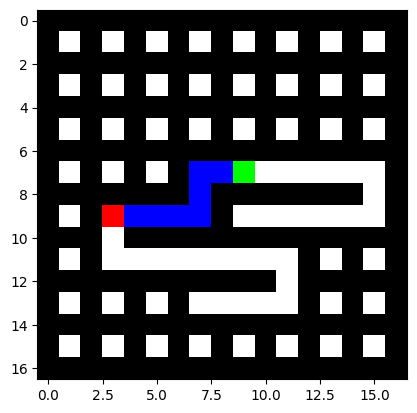

In [6]:
# process with the task
DATASET_PROMPTS: list[list[str]]; DATASET_TARGETS: list[str]
DATASET_PROMPTS, DATASET_TARGETS = LOGIT_ATTRIBUTION_TASK(DATASET_TOKENS)

DATASET_PROMPTS_JOINED: list[str] = [" ".join(prompt) for prompt in DATASET_PROMPTS]
DATASET_TARGET_IDS: Float[torch.Tensor, "n_mazes"] = torch.tensor(TOKENIZER.encode(DATASET_TARGETS), dtype=torch.long)

print("for first maze:")
print(f"full:\n{' '.join(DATASET_PROMPTS[0])}")
print(f"prompt:\n{'[...] ' + DATASET_PROMPTS_JOINED[0][-150:]}")
print(f"target:\n{DATASET_TARGETS[0]}")
print(f"target id:\n{DATASET_TARGET_IDS[0]}")
plt.imshow(DATASET[0].as_pixels())

n_mazes: int = len(DATASET_TOKENS)
d_vocab: int = TOKENIZER.vocab_size

# run model

In [7]:
LOGITS: Float[torch.Tensor, "n_mazes seq_len d_vocab"]
CACHE: ActivationCache

LOGITS, CACHE = MODEL.run_with_cache(DATASET_PROMPTS_JOINED)

In [8]:
print(f"{n_mazes = }, {d_vocab = }")
print(f"{LOGITS.shape = }")
cache_shapes: dict[str, tuple[int, ...]] = {k: v.shape for k, v in CACHE.items()}
print(f"{cache_shapes = }")

n_mazes = 100, d_vocab = 75
LOGITS.shape = torch.Size([100, 238, 75])
cache_shapes = {'hook_embed': torch.Size([100, 238, 128]), 'hook_pos_embed': torch.Size([100, 238, 128]), 'blocks.0.hook_resid_pre': torch.Size([100, 238, 128]), 'blocks.0.ln1.hook_scale': torch.Size([100, 238, 1]), 'blocks.0.ln1.hook_normalized': torch.Size([100, 238, 128]), 'blocks.0.attn.hook_q': torch.Size([100, 238, 4, 32]), 'blocks.0.attn.hook_k': torch.Size([100, 238, 4, 32]), 'blocks.0.attn.hook_v': torch.Size([100, 238, 4, 32]), 'blocks.0.attn.hook_attn_scores': torch.Size([100, 4, 238, 238]), 'blocks.0.attn.hook_pattern': torch.Size([100, 4, 238, 238]), 'blocks.0.attn.hook_z': torch.Size([100, 238, 4, 32]), 'blocks.0.hook_attn_out': torch.Size([100, 238, 128]), 'blocks.0.hook_resid_mid': torch.Size([100, 238, 128]), 'blocks.0.ln2.hook_scale': torch.Size([100, 238, 1]), 'blocks.0.ln2.hook_normalized': torch.Size([100, 238, 128]), 'blocks.0.mlp.hook_pre': torch.Size([100, 238, 512]), 'blocks.0.mlp.hook_post':

we expect the logits to have shape `(n_mazes, n_tokens, n_vocab)`


## get and evaluate predictions

these should have shape `(n_mazes, n_vocab)`

In [9]:
LAST_TOK_LOGITS: Float[torch.Tensor, "n_mazes d_vocab"] = LOGITS[:, -1, :]
print(f"{LAST_TOK_LOGITS.shape = }")

LAST_TOK_LOGITS.shape = torch.Size([100, 75])


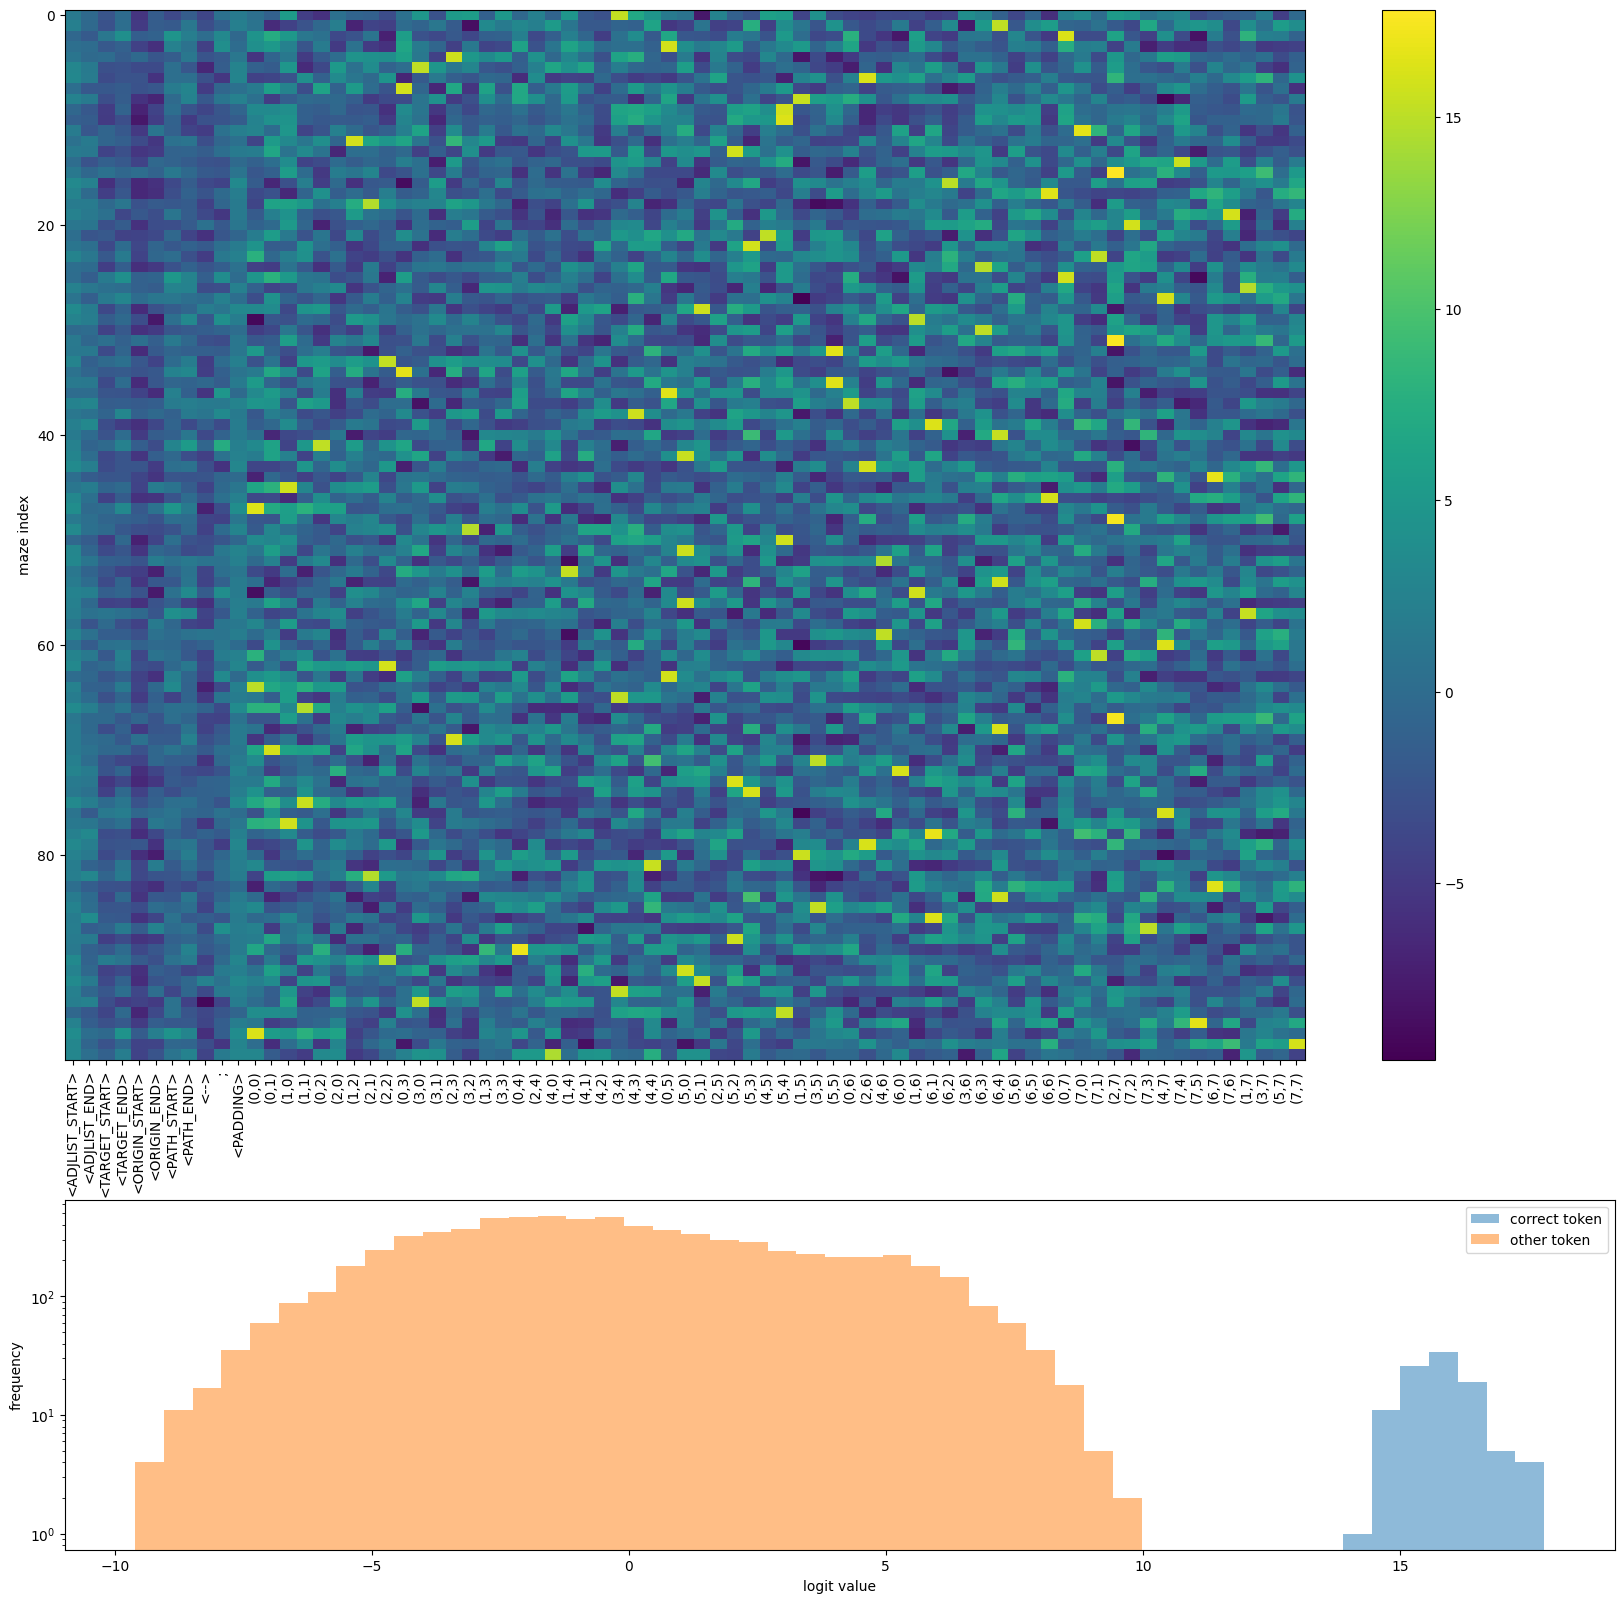

(<Figure size 2000x2000 with 3 Axes>,
 (<Axes: xlabel='vocab element logit', ylabel='maze index'>,
  <Axes: xlabel='logit value', ylabel='frequency'>))

In [10]:
plot_logits(
    last_tok_logits=LAST_TOK_LOGITS,
    target_idxs=DATASET_TARGET_IDS,
    tokenizer=TOKENIZER,
    n_bins=50,
    density=False,
    logy=True,
)

In [11]:
PREDICTED_TOKENS: list[str] = TOKENIZER.decode(LAST_TOK_LOGITS.argmax(dim=-1).tolist())
print(f"{len(PREDICTED_TOKENS) = }")
print(f"{DATASET_TARGETS[0] = }")
print(f"{PREDICTED_TOKENS[0] = }")

len(PREDICTED_TOKENS) = 100
DATASET_TARGETS[0] = '(3,4)'
PREDICTED_TOKENS[0] = '(3,4)'


## overall accuracy

In [12]:
prediction_correct: Bool[torch.Tensor, "n_mazes"] = torch.tensor([
	pred == target 
	for pred, target in zip(PREDICTED_TOKENS, DATASET_TARGETS)
])

# print(f"{prediction_correct.shape = }")
print(f"{prediction_correct.float().mean().item() = }")

prediction_correct.float().mean().item() = 1.0


# Results

## logit diff

A logit difference $d$ can be interpreted as the model being $e^{d}$ times more likely to choose the correct response. Here, the `test` column tells us what token we are comparing: `taget` (correct) token, `predicted` (argmax sample) token, and `sampled` (sampled from logits) token. Also included are `noise={p}` (predicted with gaussian noise added to logits) and `random_r{i}` (a fully random one-hot vector). We compare these to either `all` other logits, or a `random` other vector.

           test compare_to  result_orig  result_res       diff     ratio
0        target        all    31.570227   13.288536  18.281691  2.375749
1     predicted        all    31.570227   13.288536  18.281691  2.375749
2       sampled        all    31.377092   13.166064  18.211028  2.383179
3    noise=1.00        all    31.570227   13.288536  18.281691  2.375749
4    noise=2.00        all    31.570227   13.288536  18.281691  2.375749
5    noise=3.00        all    29.470163   12.415531  17.054632  2.373653
6    noise=5.00        all    22.912979    9.969104  12.943875  2.298399
7   noise=10.00        all    11.777624    4.869315   6.908309  2.418743
8     random_r0        all     0.692738    0.412883   0.279854  1.677805
9        target     random    16.192577   13.690259   2.502318  1.182781
10    predicted     random    16.192577   13.690259   2.502318  1.182781
11      sampled     random    16.096014   13.604667   2.491347  1.183124
12   noise=1.00     random    16.192577   13.690259

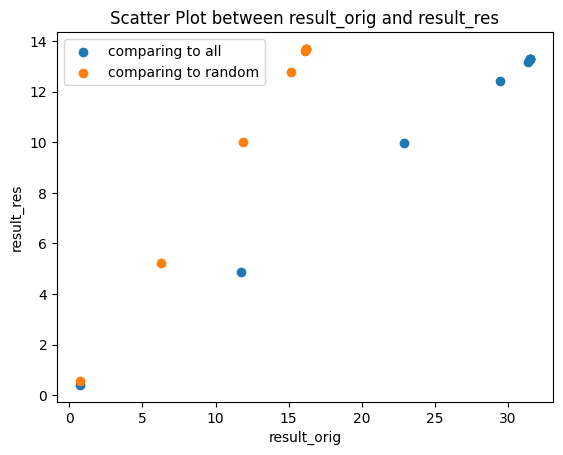

In [13]:
LOGIT_DIFF_DF: pd.DataFrame = logits_diff_multi(
	model=MODEL,
	cache=CACHE,
	dataset_target_ids=DATASET_TARGET_IDS,
	last_tok_logits=LAST_TOK_LOGITS,
	# noise_sigmas=np.logspace(0, 3, 100),
)

print(LOGIT_DIFF_DF)

# scatter separately for "all" vs "random"
fig, ax = plt.subplots()
for compare_to in ["all", "random"]:
	df = LOGIT_DIFF_DF[LOGIT_DIFF_DF["compare_to"] == compare_to]
	ax.scatter(
		df['result_orig'], df['result_res'], 
		label=f"comparing to {compare_to}",
		marker='o',
	)
ax.legend()
plt.xlabel('result_orig')
plt.ylabel('result_res')
plt.title('Scatter Plot between result_orig and result_res')
plt.show()


## logit lens

Here, we test the logit difference of the correct token at various layers

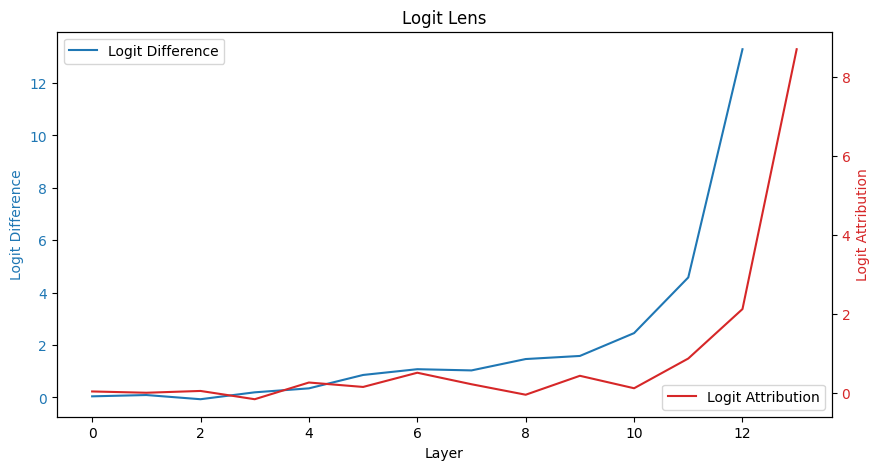

In [14]:
figax, results = plot_logit_lens(
    model=MODEL,
    cache=CACHE,
    answer_tokens=DATASET_TARGET_IDS,
)

## direct logit attribution

Tried to stack head results when they weren't cached. Computing head results now


Text(0.5, 1.0, "Logit difference from each head\nhallway-medium\n'origin_after_path_start' task")

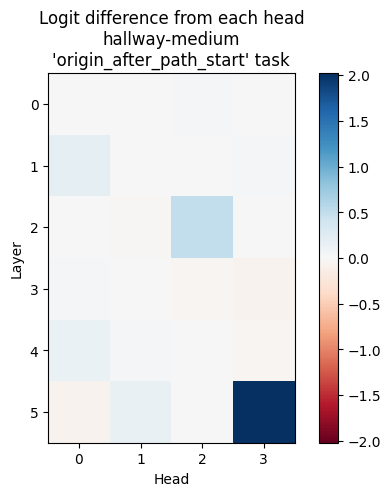

In [15]:
fig, ax, DLA_DATA = plot_direct_logit_attribution(
	model=MODEL,
	cache=CACHE,
    answer_tokens=DATASET_TARGET_IDS,
    show=False,
)
ax.set_title(f"Logit difference from each head\n{MODEL.zanj_model_config.name}\n'{LOGIT_ATTRIBUTION_TASK_NAME}' task")

important_heads = [(5, 3, 2.0219593), (2, 2, 0.50334364), (1, 0, 0.1974559), (5, 1, 0.15186825), (4, 0, 0.13730036)]
CACHE.keys() = dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'bloc

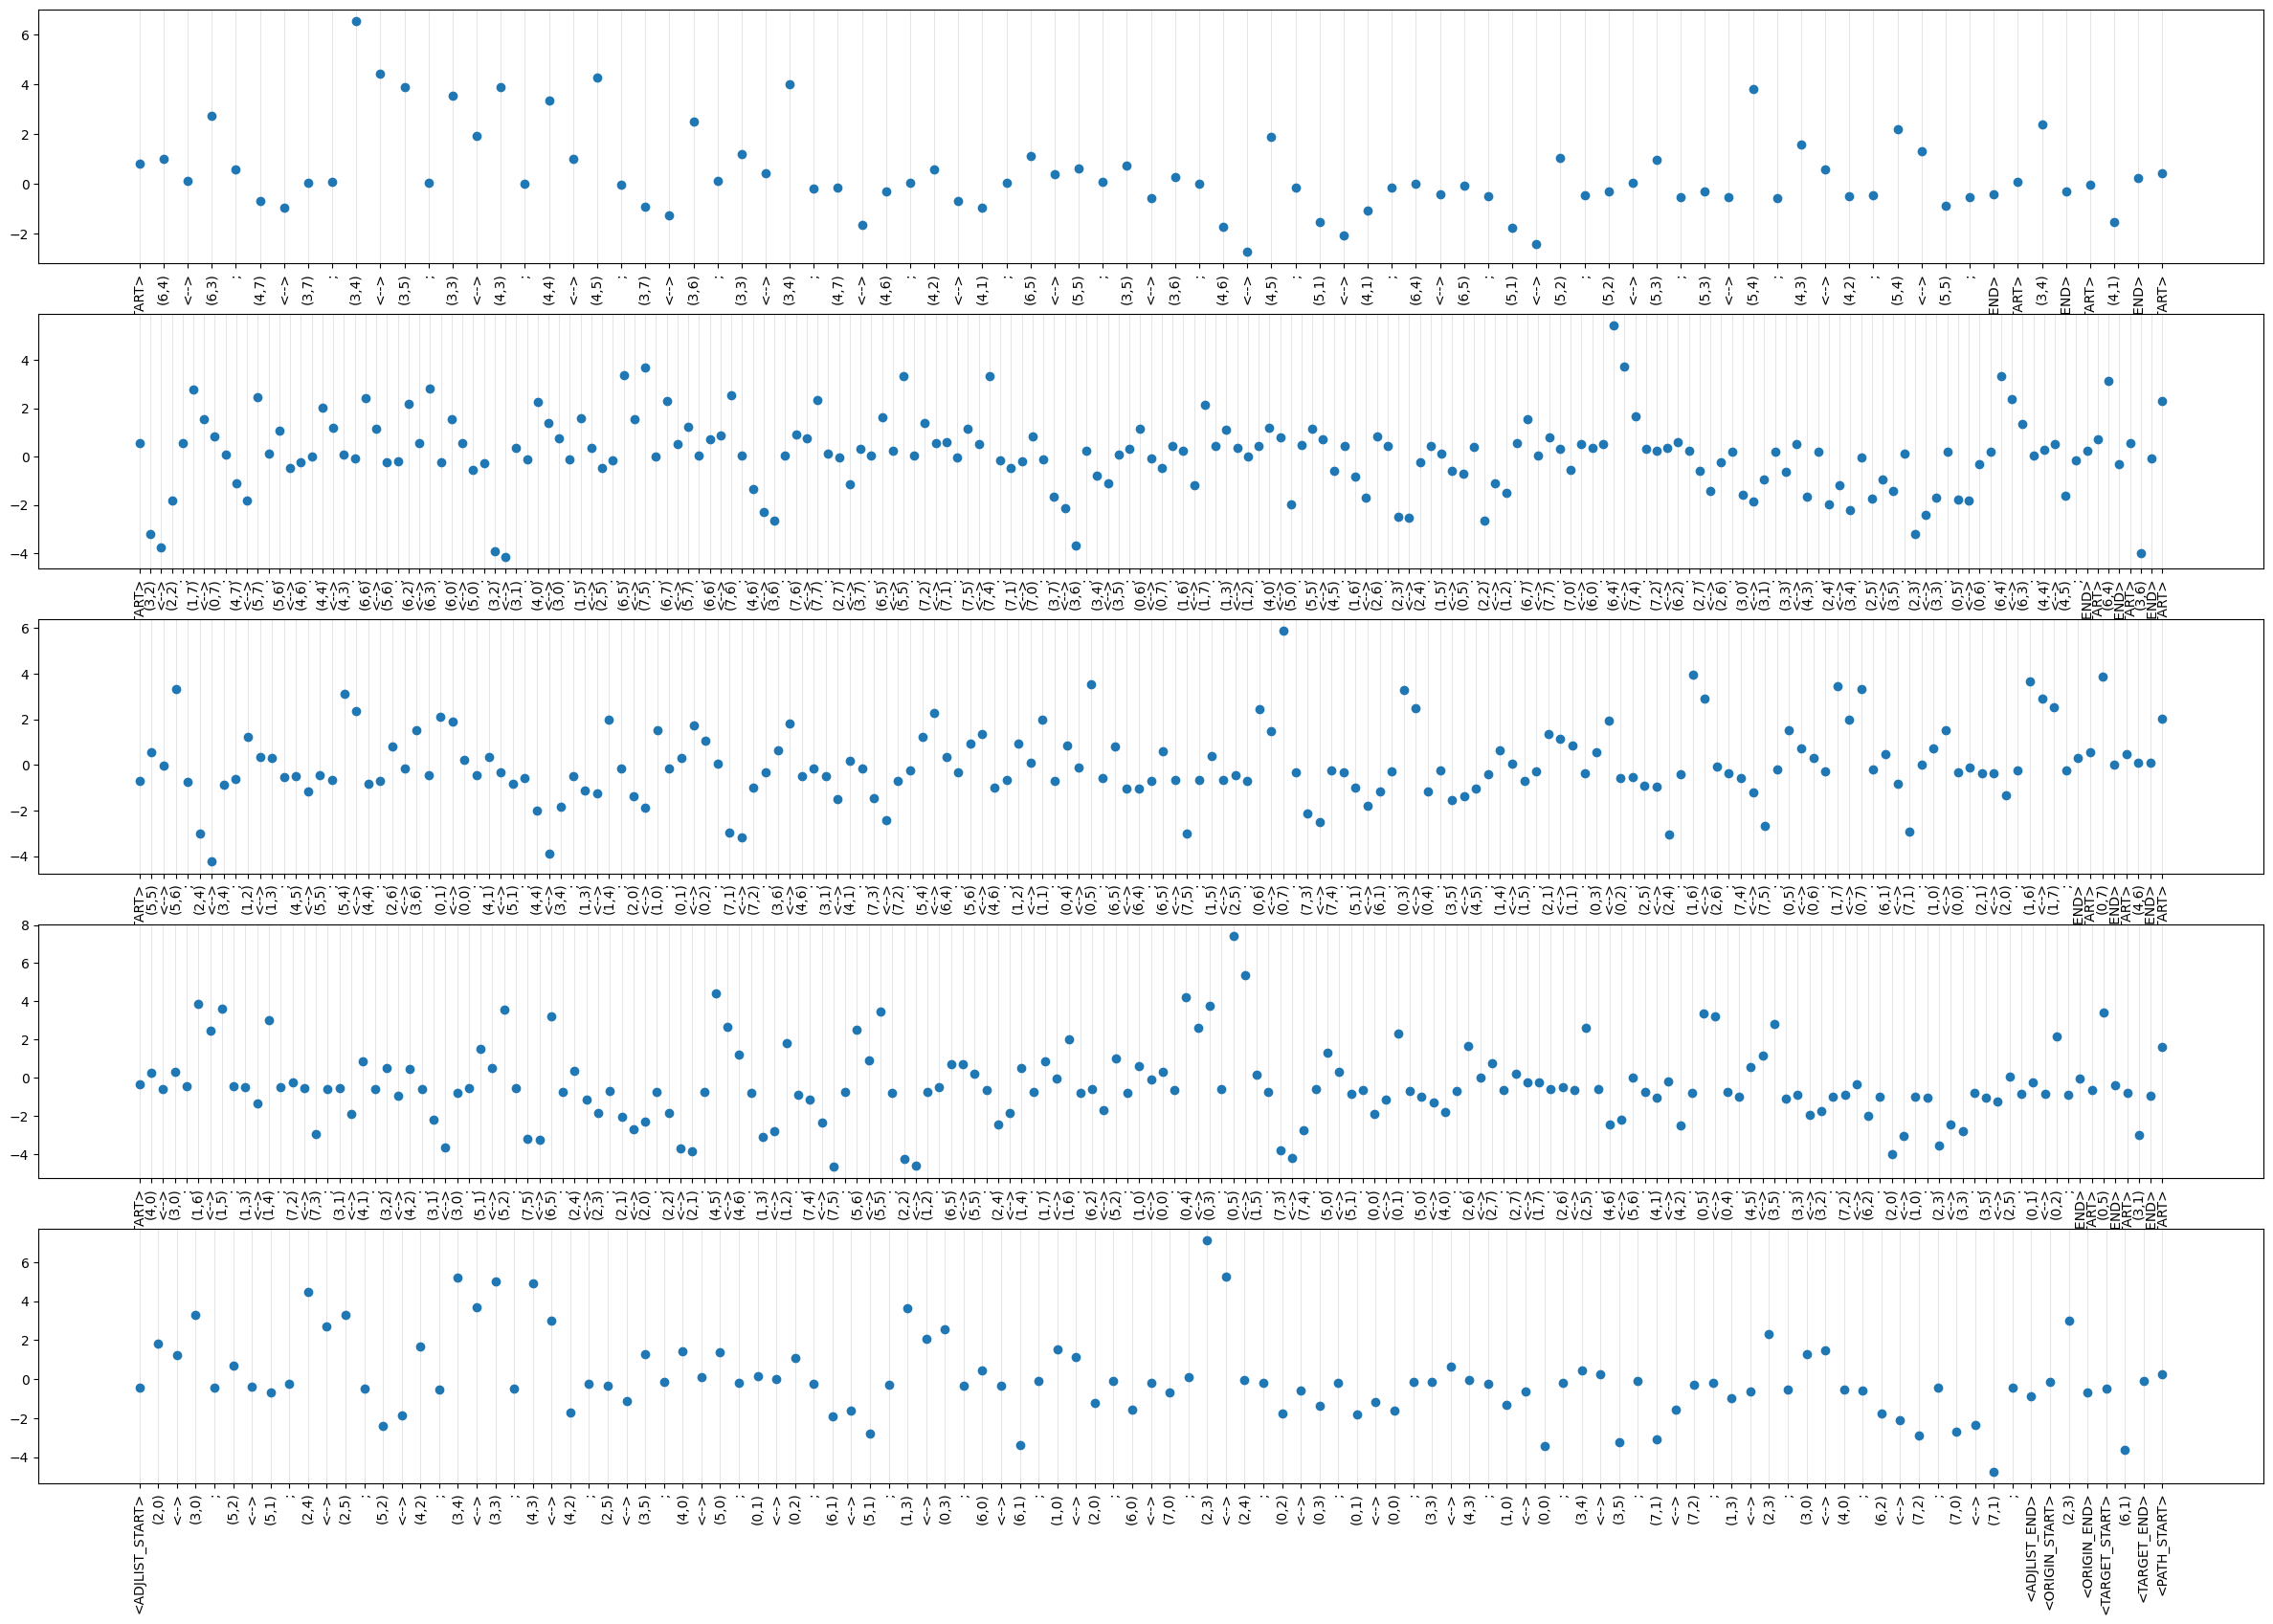

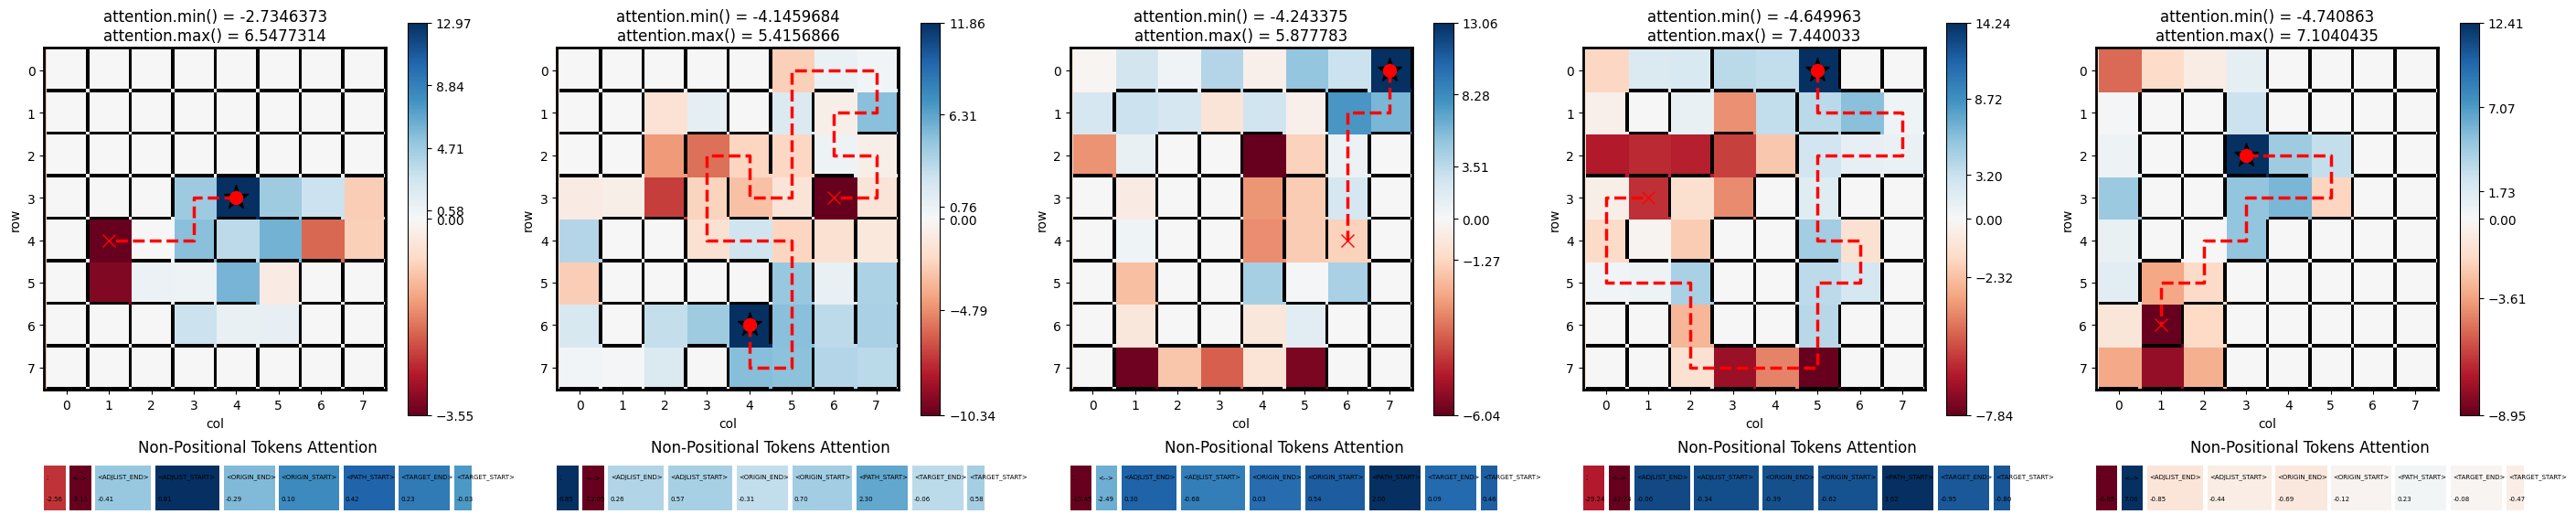

--------------------------------------------------------------------------------
head: layer_2.head_2, score: c = 0.50334364, v.shape = (100, 238, 238)
(5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
2.8   -0.5 -0.6    3.0   -0.1 3.0     1.6   -0.8 0.1     5.3           1.6            9.9   2.2          1.3            4.9   2.6          1.7          
(0,5) <--> (0,6) ; (6,4) <--> (6,3) ; (4,4) <--> (4,5) ; <ADJLIST_END> <ORIGIN_START> (6,4) <ORIGIN_END> <TARGET_START> (3,6) <TARGET_END> <PATH_START>
1.8   -0.8 1.0     1.7   -1.5 3.9     1.9   -1.5 1.0     5.5           1.9            10.3  2.4          1.6            5.2   3.1          1.7          
(1,0) <--> (0,0) ; (2,1) <--> (2,0) ; (1,6) <--> (1,7) ; <ADJLIST_END> <ORIGIN_START> (0,7) <ORIGIN_END> <TARGET_START> (4,6) <TARGET_END> <PATH_START>
3.5   0.9  4.4     2.4   0.3  3.9     2.0   -0.5 2.9     5.5           2.4            

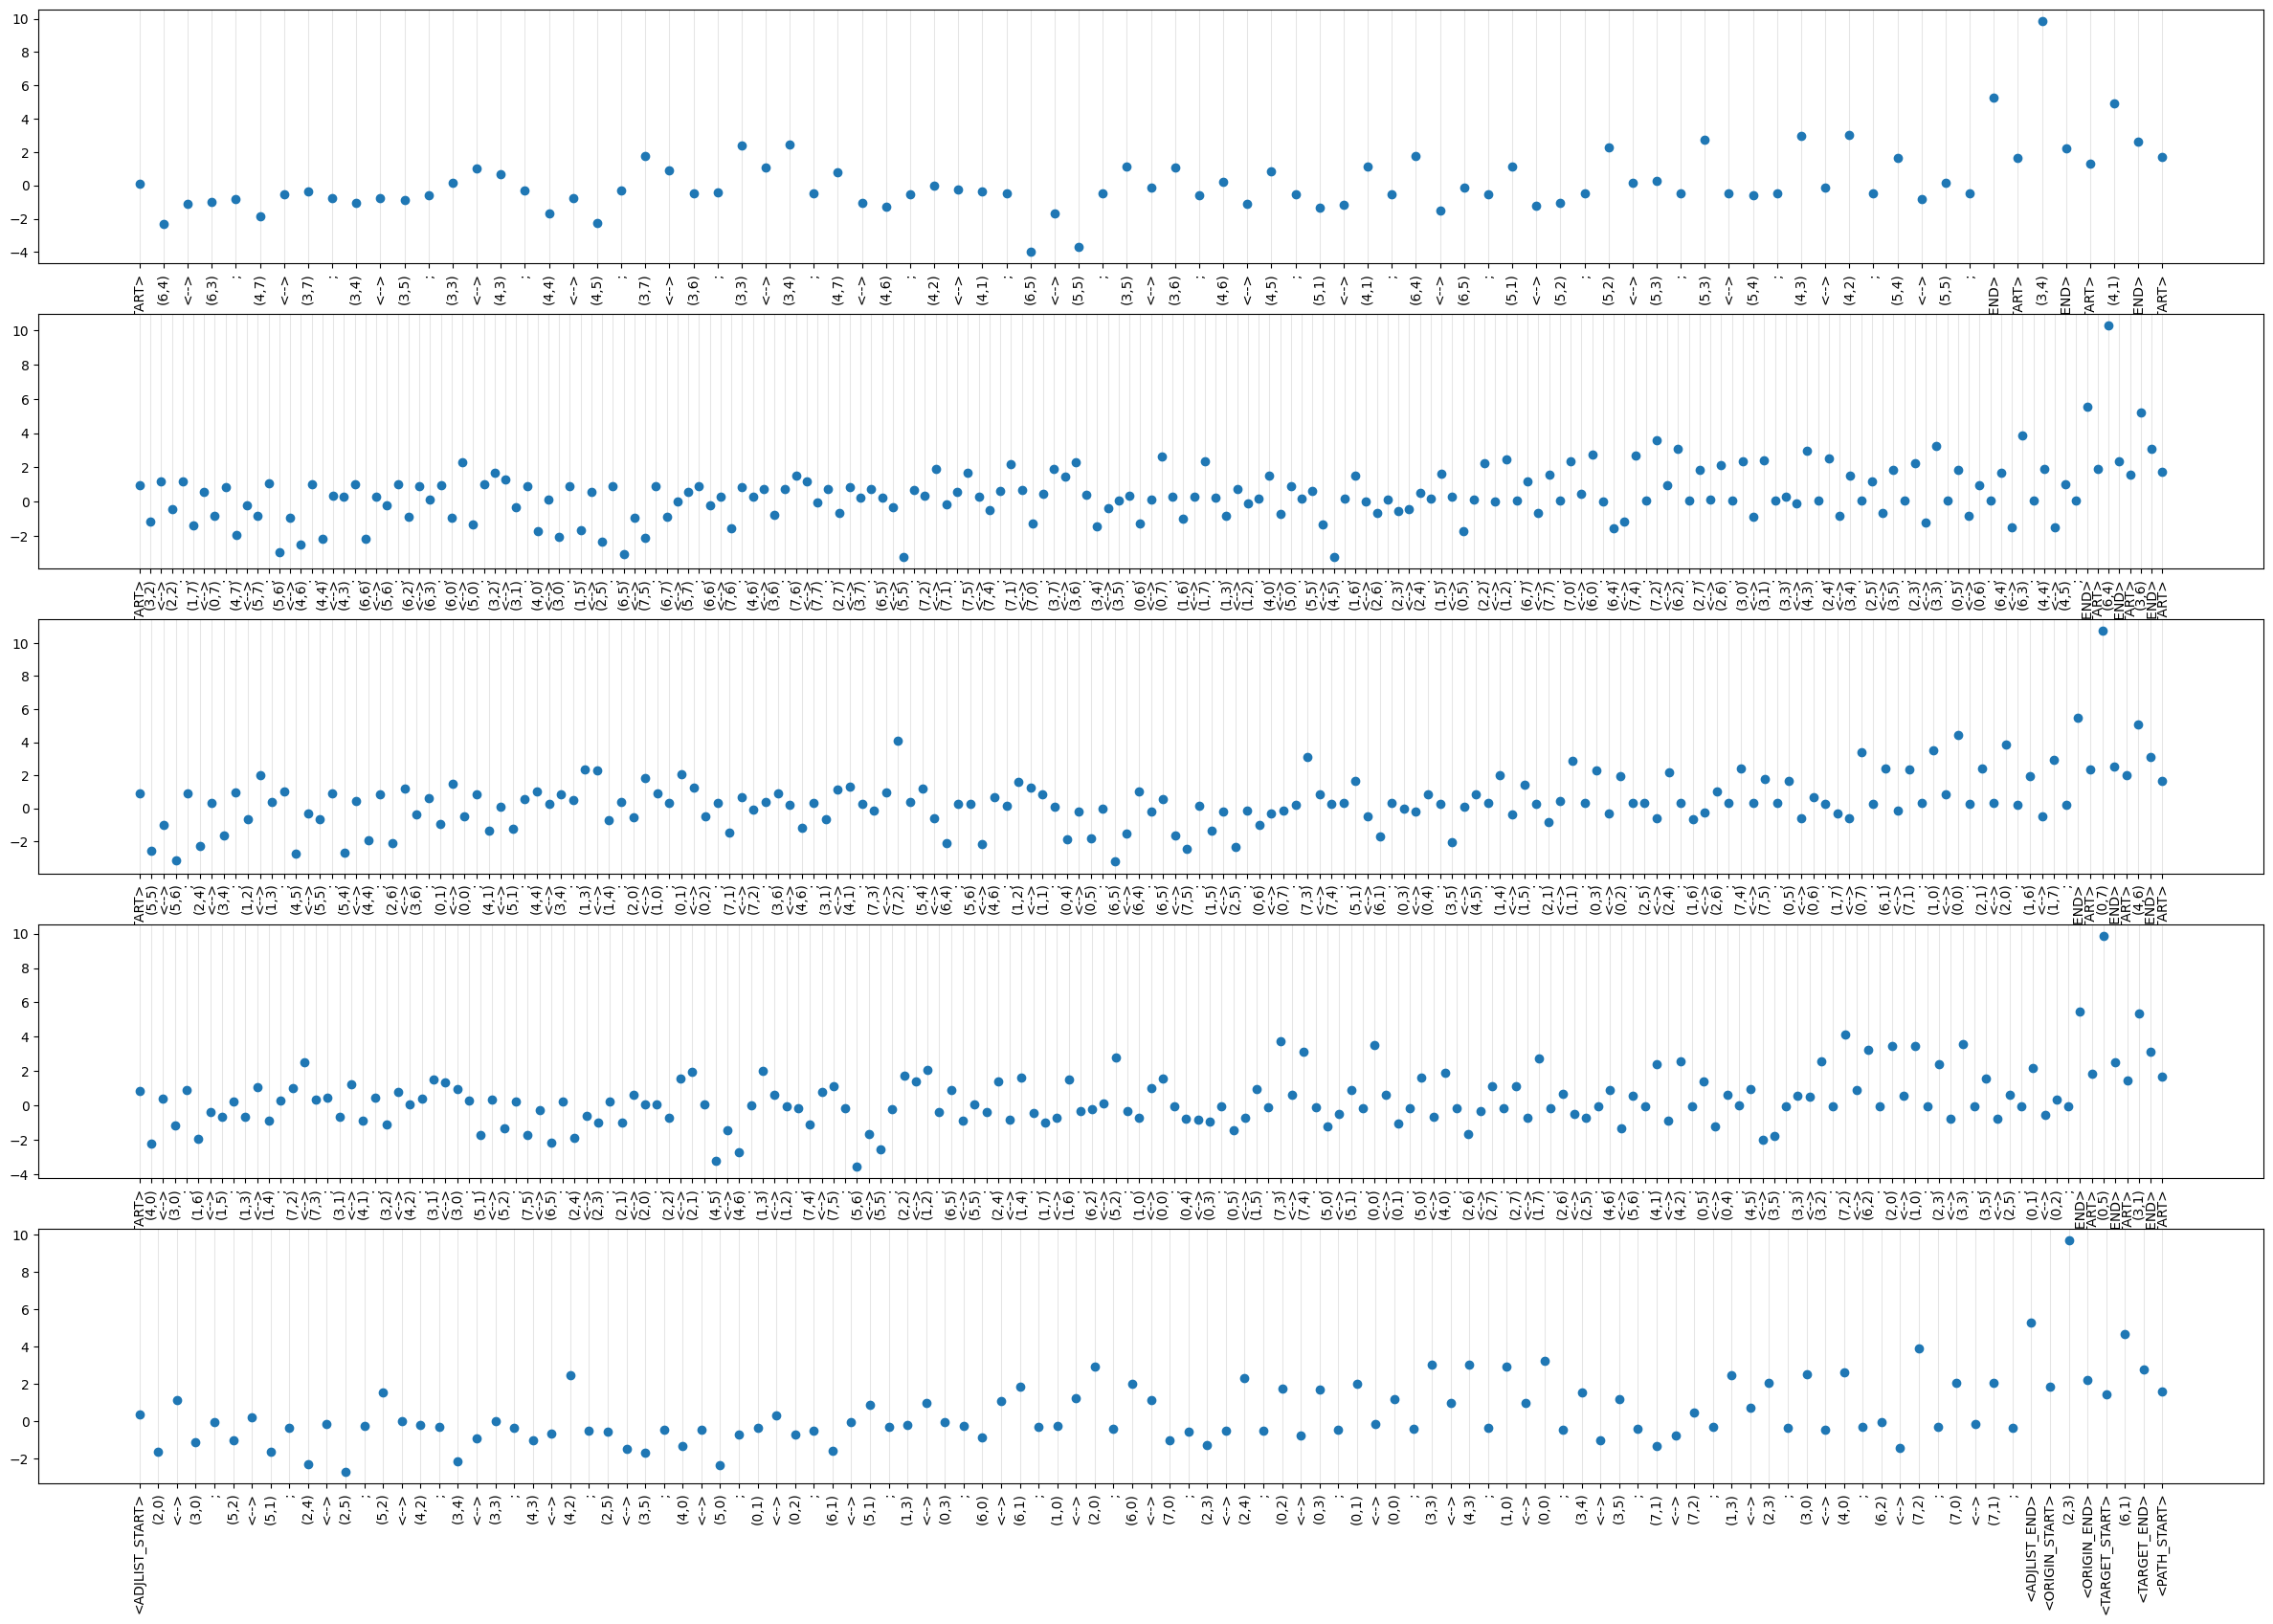

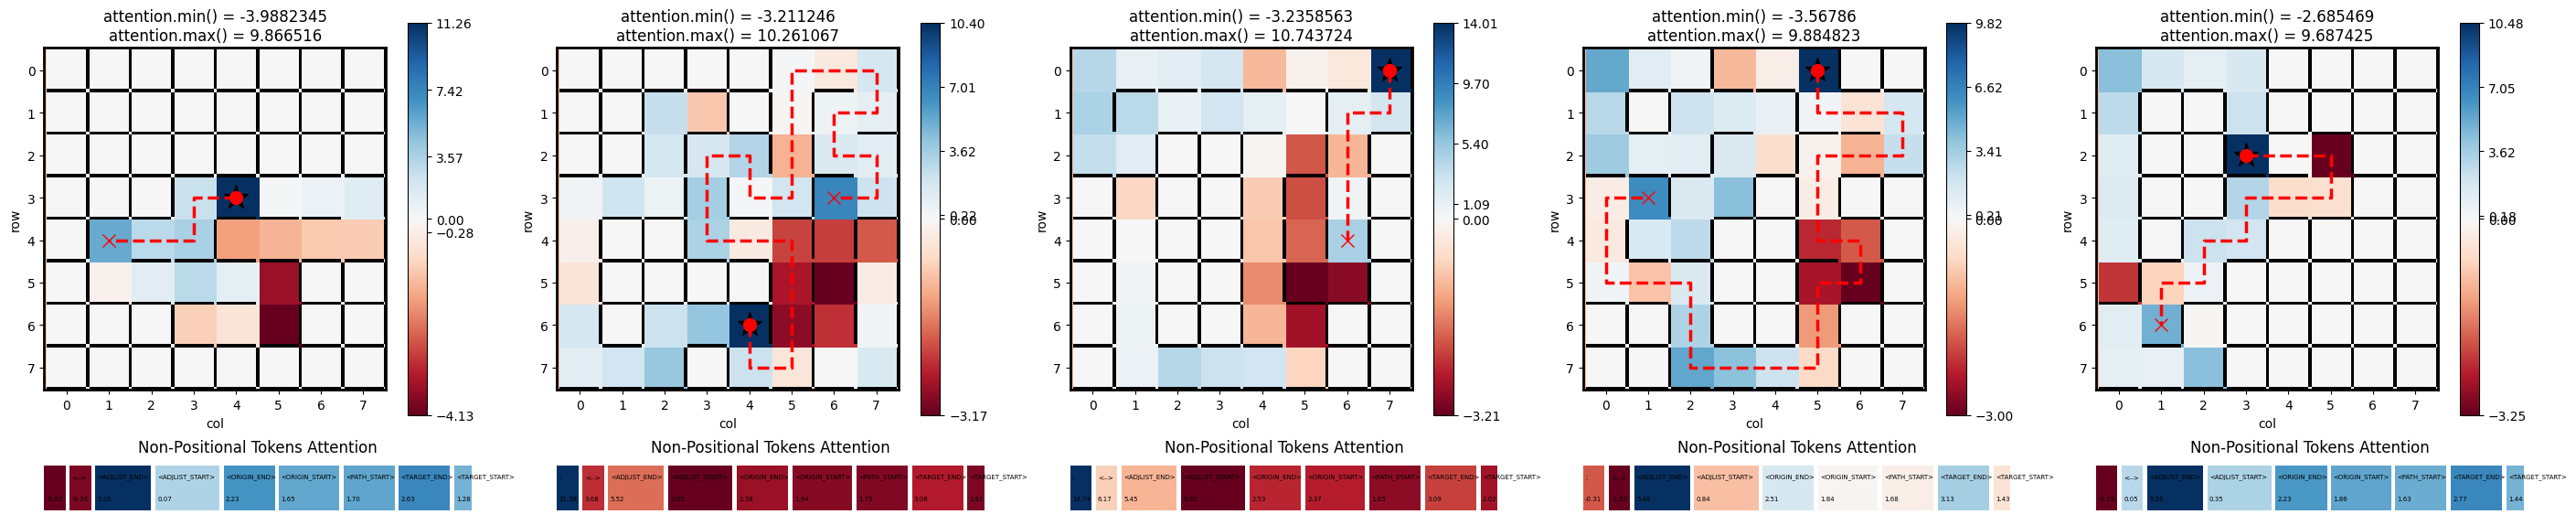

--------------------------------------------------------------------------------
head: layer_1.head_0, score: c = 0.1974559, v.shape = (100, 238, 238)
(5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
2.0   1.0  1.6     1.5   0.3  2.9     1.4   -0.0 -1.1    10.5          -0.6           1.7   16.3         -1.1           2.3   9.2          4.1          
(0,5) <--> (0,6) ; (6,4) <--> (6,3) ; (4,4) <--> (4,5) ; <ADJLIST_END> <ORIGIN_START> (6,4) <ORIGIN_END> <TARGET_START> (3,6) <TARGET_END> <PATH_START>
-2.8  -2.9 -3.3    -0.3  -1.5 2.7     -2.1  -1.3 -1.3    10.8          1.7            0.1   18.2         1.3            -1.1  9.8          4.7          
(1,0) <--> (0,0) ; (2,1) <--> (2,0) ; (1,6) <--> (1,7) ; <ADJLIST_END> <ORIGIN_START> (0,7) <ORIGIN_END> <TARGET_START> (4,6) <TARGET_END> <PATH_START>
0.9   -0.6 1.0     2.1   0.1  1.1     -3.6  -2.3 -3.9    10.8          -0.1           -

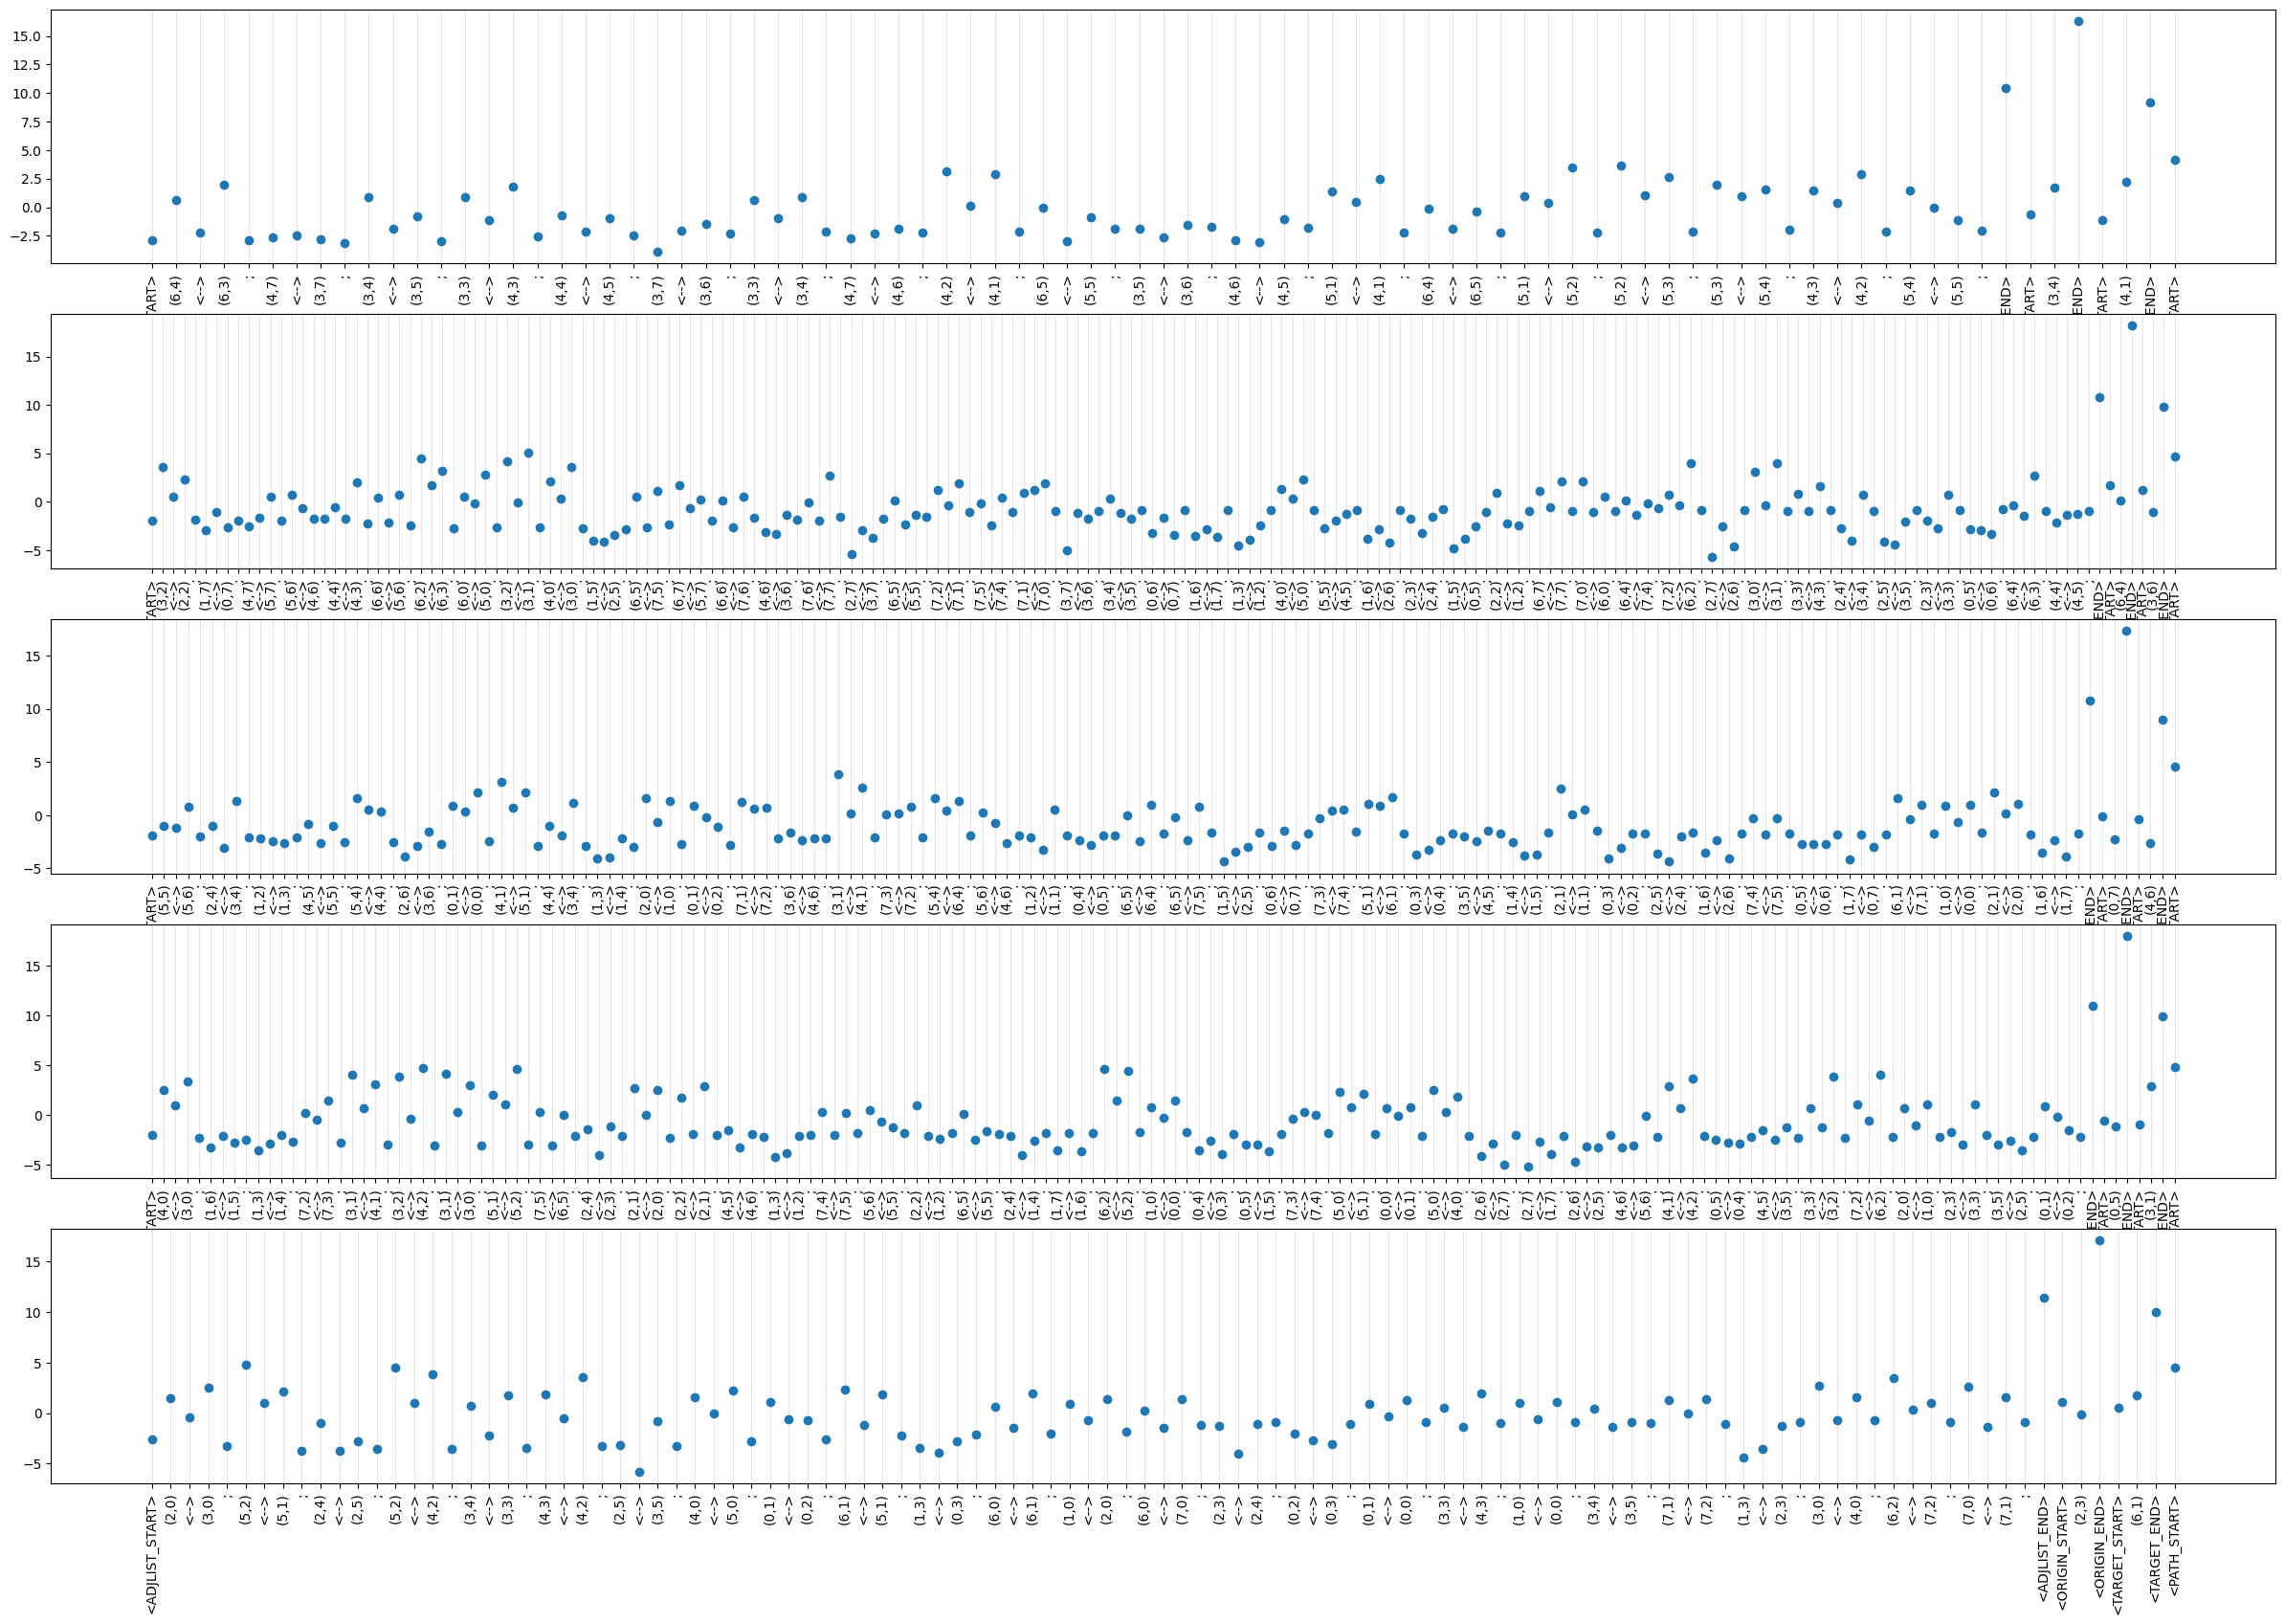

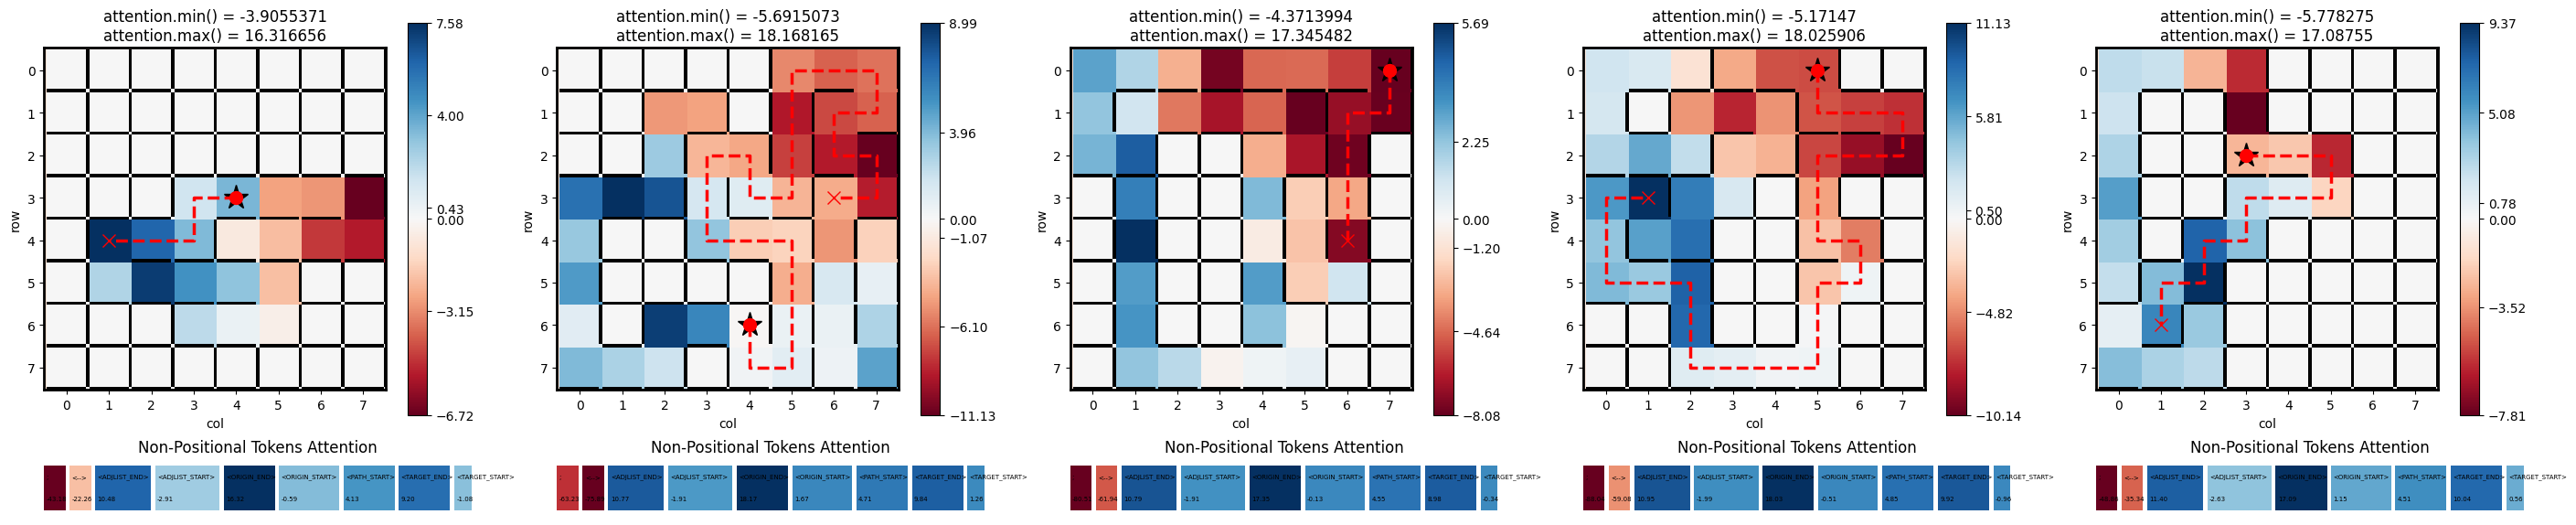

--------------------------------------------------------------------------------
head: layer_5.head_1, score: c = 0.15186825, v.shape = (100, 238, 238)
(5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
-1.3  -0.0 -0.3    -0.2  0.1  0.1     -0.6  -0.1 -0.8    0.5           0.5            0.3   -0.1         0.5            -1.2  0.3          -0.7         
(0,5) <--> (0,6) ; (6,4) <--> (6,3) ; (4,4) <--> (4,5) ; <ADJLIST_END> <ORIGIN_START> (6,4) <ORIGIN_END> <TARGET_START> (3,6) <TARGET_END> <PATH_START>
-1.2  -0.5 -0.4    0.9   1.5  0.5     -1.3  0.4  -1.2    -0.6          1.4            0.9   0.0          1.2            -1.2  -0.2         0.9          
(1,0) <--> (0,0) ; (2,1) <--> (2,0) ; (1,6) <--> (1,7) ; <ADJLIST_END> <ORIGIN_START> (0,7) <ORIGIN_END> <TARGET_START> (4,6) <TARGET_END> <PATH_START>
-0.8  -0.1 -1.5    -0.7  -1.2 -1.8    1.3   1.7  2.0     -1.1          0.3            

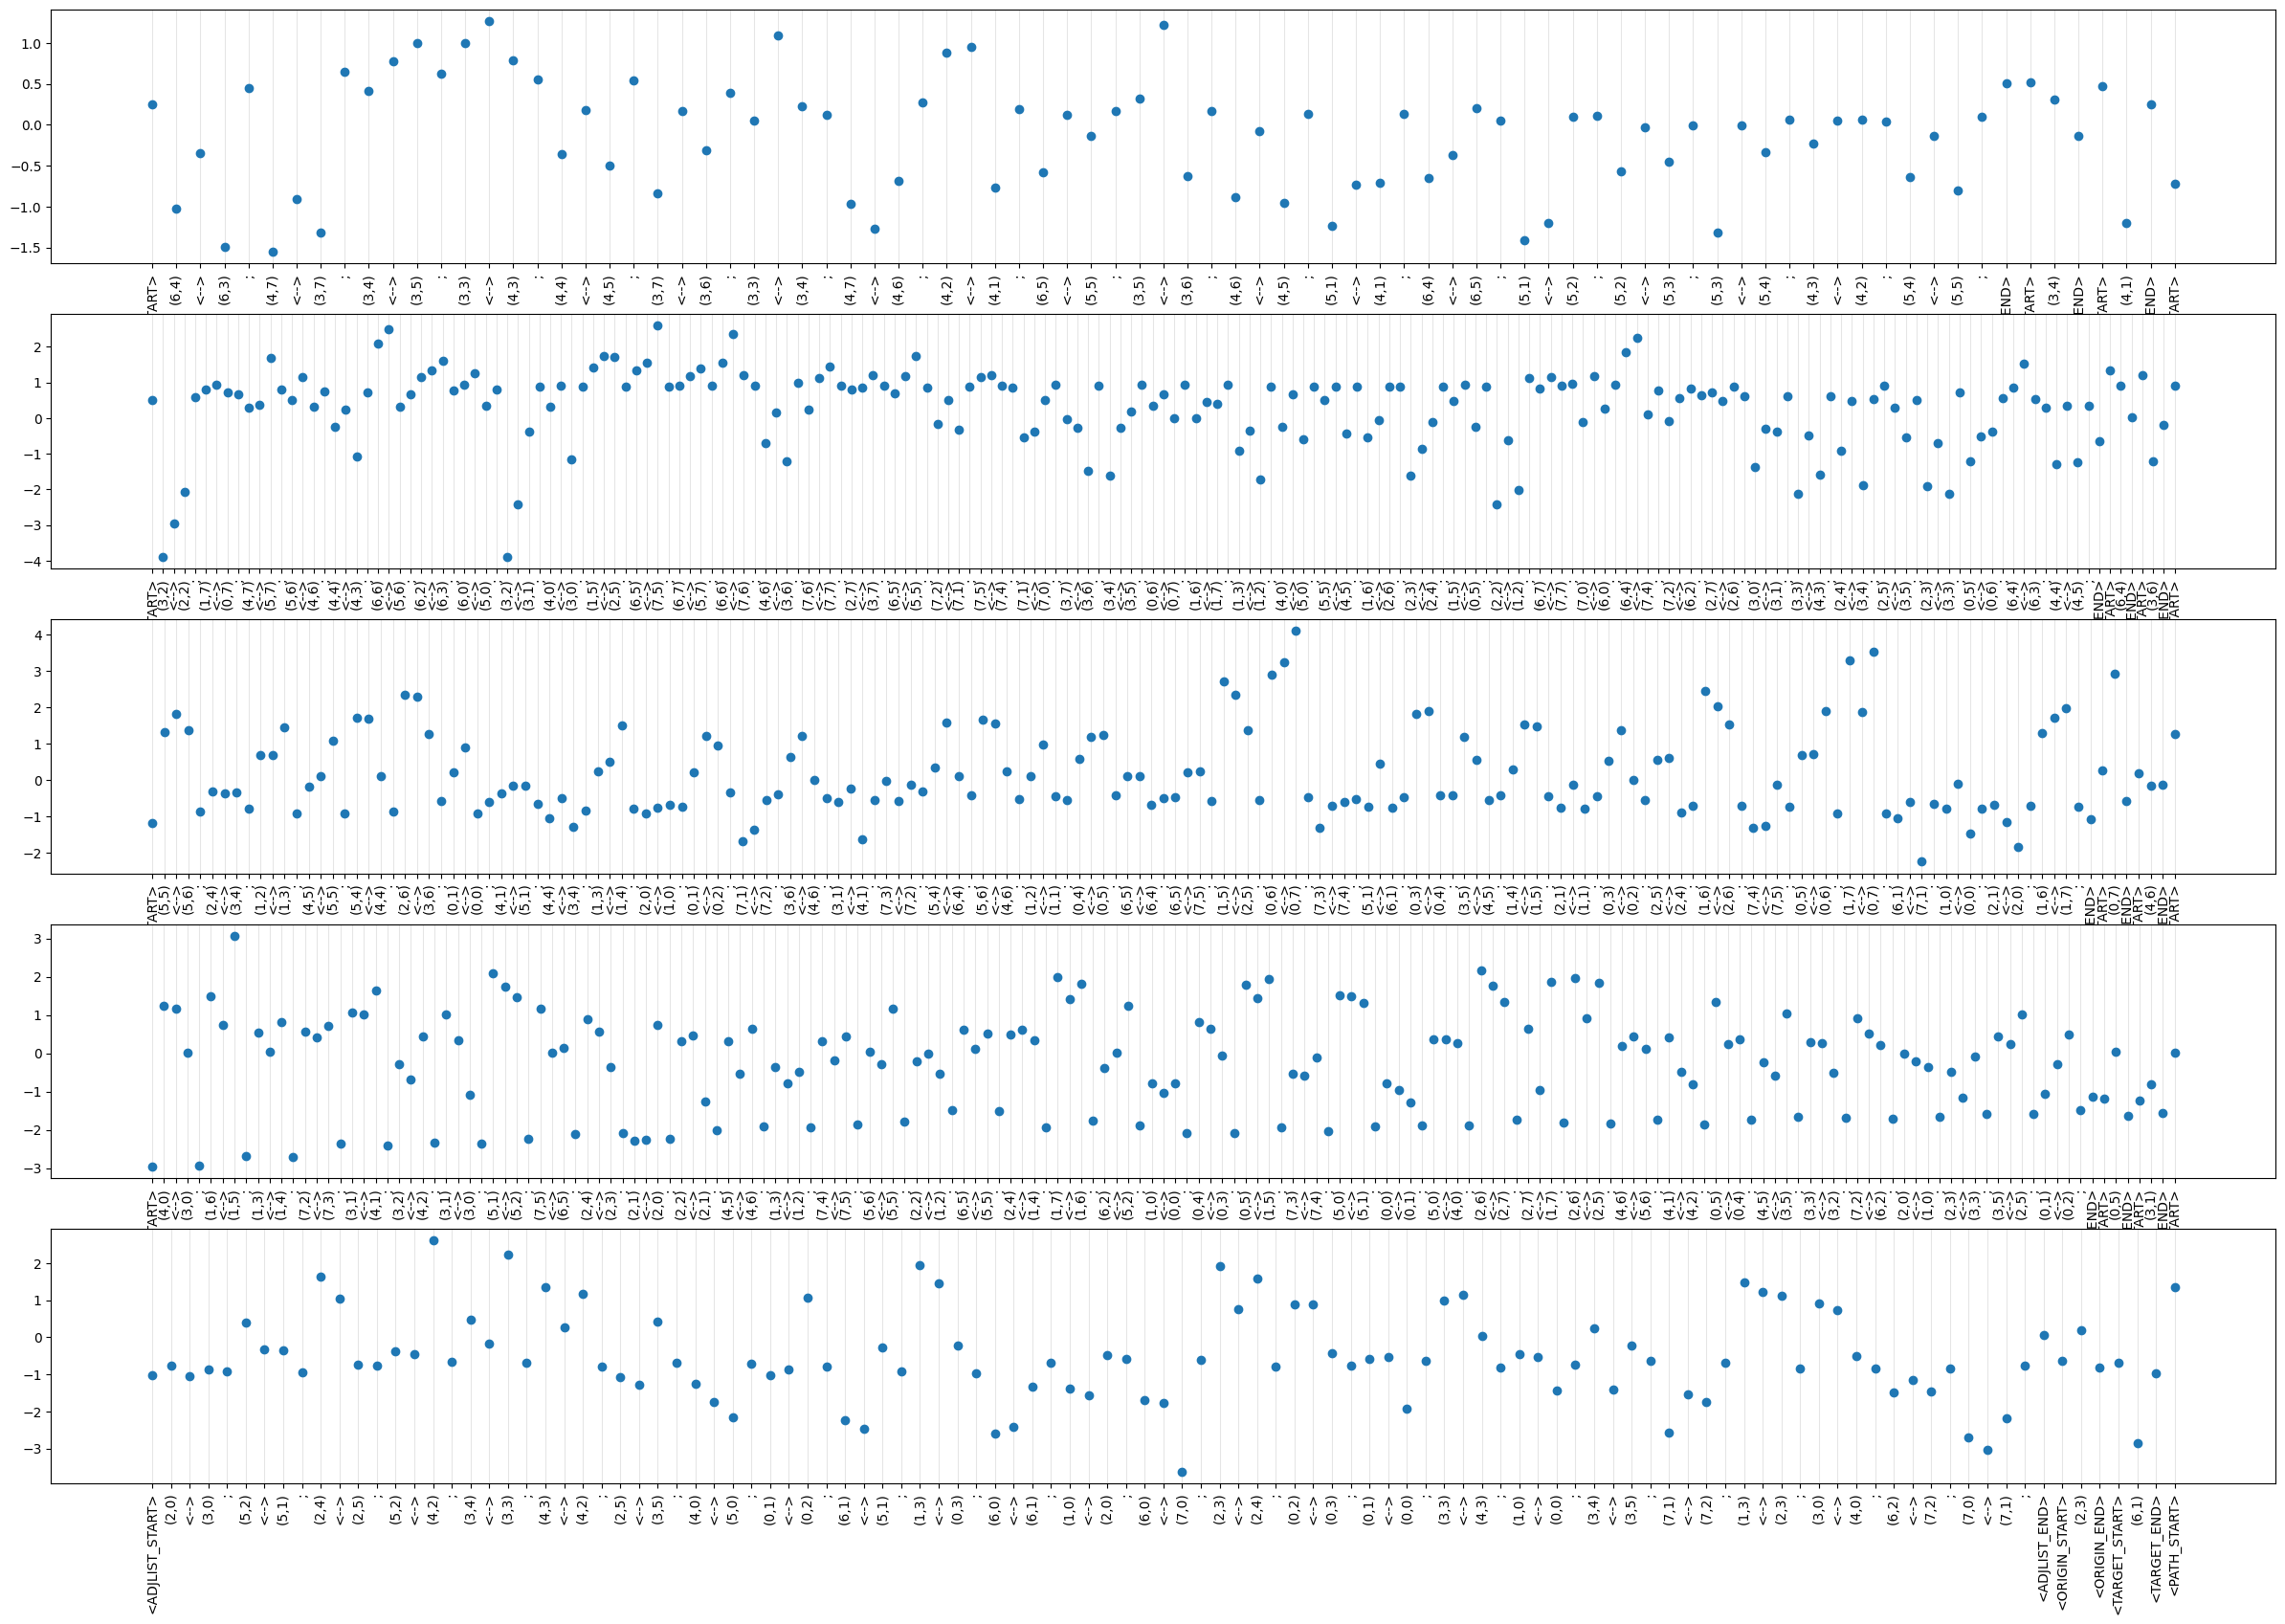

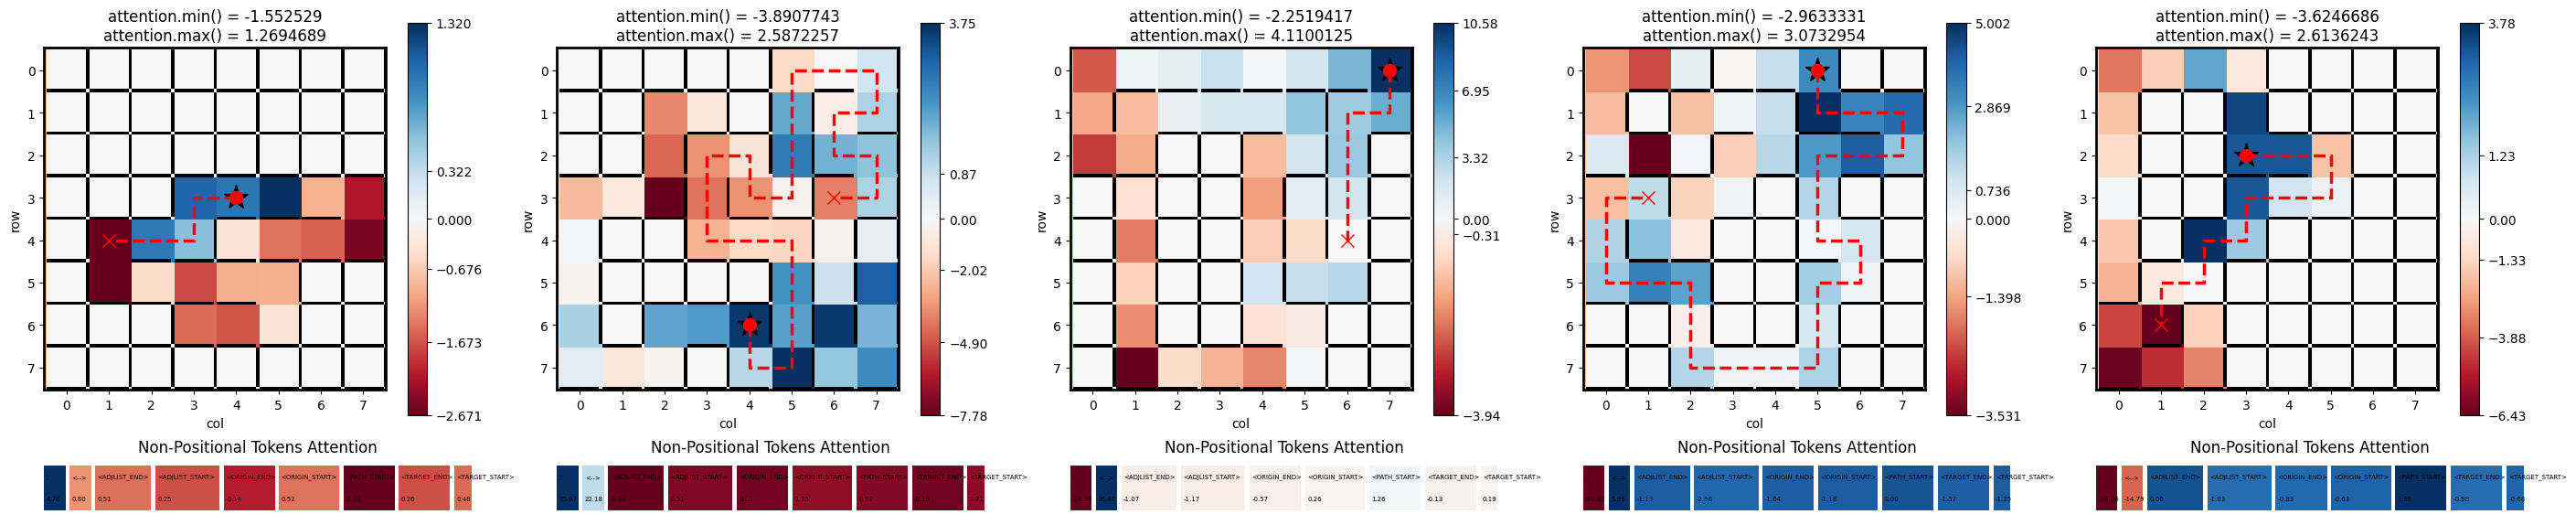

--------------------------------------------------------------------------------
head: layer_4.head_0, score: c = 0.13730036, v.shape = (100, 238, 238)
(5,3) <--> (5,4) ; (4,3) <--> (4,2) ; (5,4) <--> (5,5) ; <ADJLIST_END> <ORIGIN_START> (3,4) <ORIGIN_END> <TARGET_START> (4,1) <TARGET_END> <PATH_START>
0.1   -0.8 -0.8    1.3   0.1  0.8     1.5   -0.6 -5.2    4.6           -1.0           5.5   3.1          -1.1           3.7   1.7          -1.2         
(0,5) <--> (0,6) ; (6,4) <--> (6,3) ; (4,4) <--> (4,5) ; <ADJLIST_END> <ORIGIN_START> (6,4) <ORIGIN_END> <TARGET_START> (3,6) <TARGET_END> <PATH_START>
3.7   0.2  1.7     5.0   1.2  4.9     -1.2  -2.0 -4.4    5.1           0.4            8.6   3.1          0.3            -2.9  3.8          0.9          
(1,0) <--> (0,0) ; (2,1) <--> (2,0) ; (1,6) <--> (1,7) ; <ADJLIST_END> <ORIGIN_START> (0,7) <ORIGIN_END> <TARGET_START> (4,6) <TARGET_END> <PATH_START>
-0.4  -1.3 1.7     2.3   2.6  -0.8    2.2   -0.5 1.9     5.1           0.9            

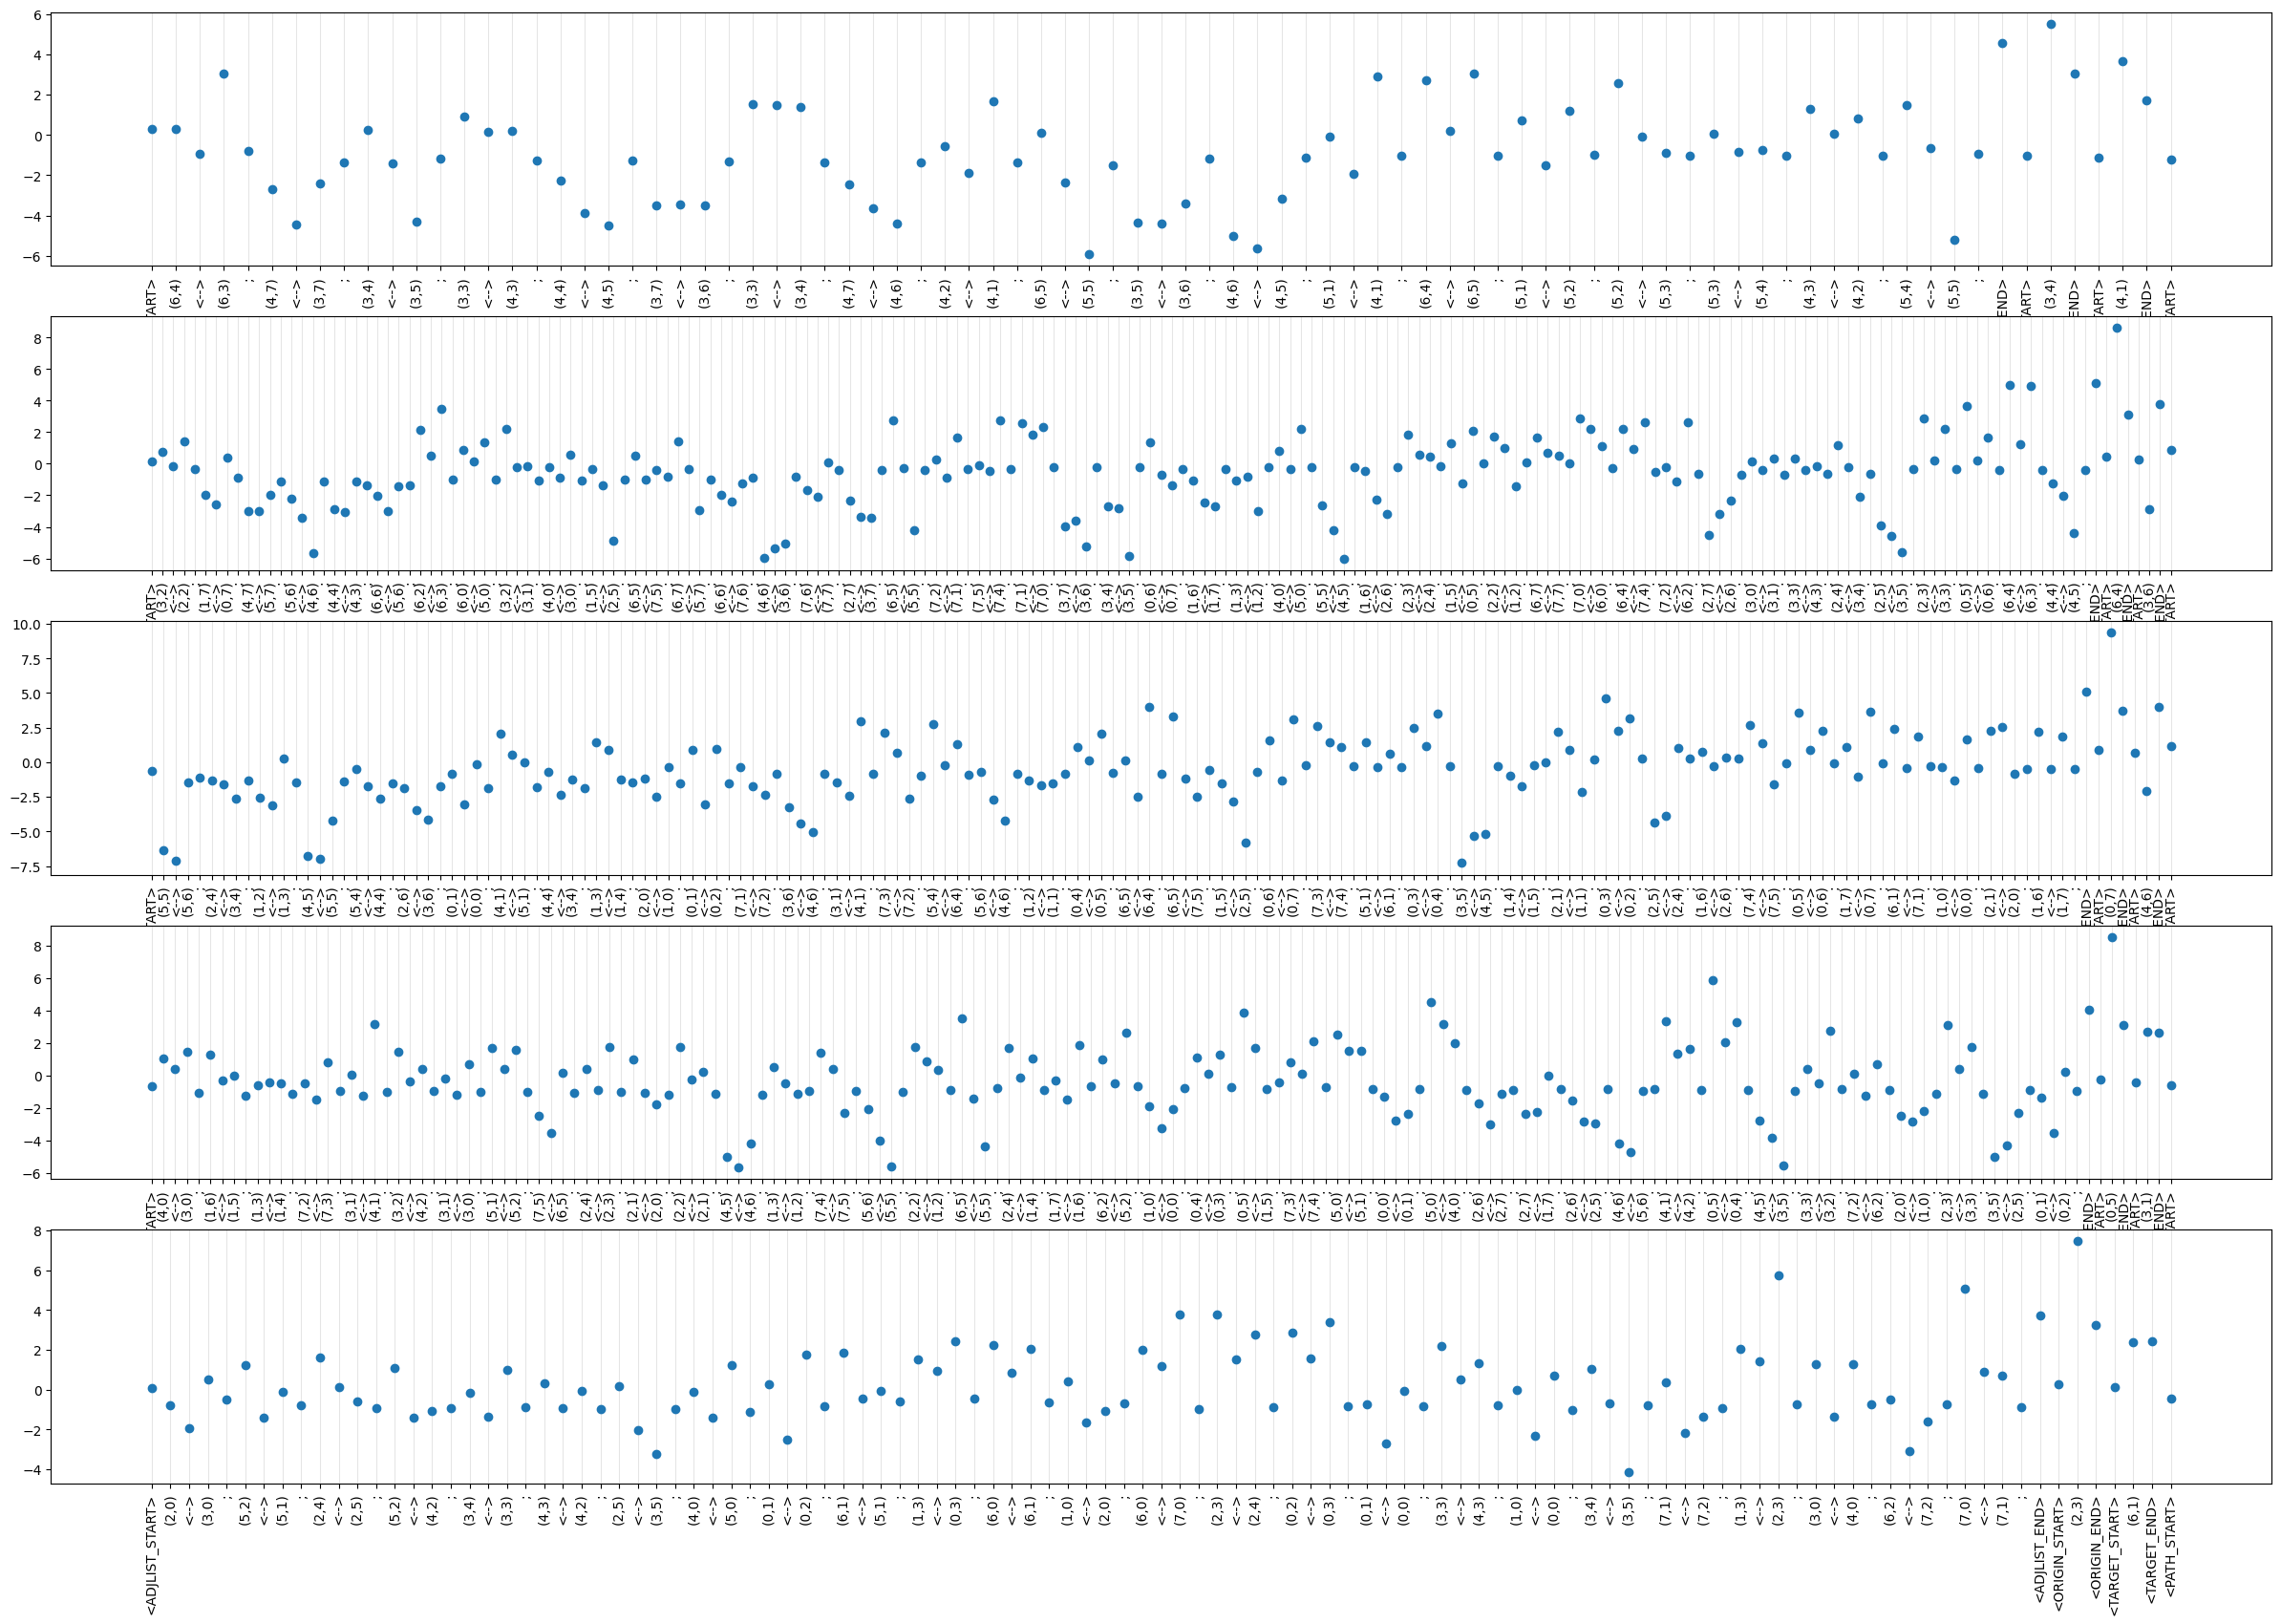

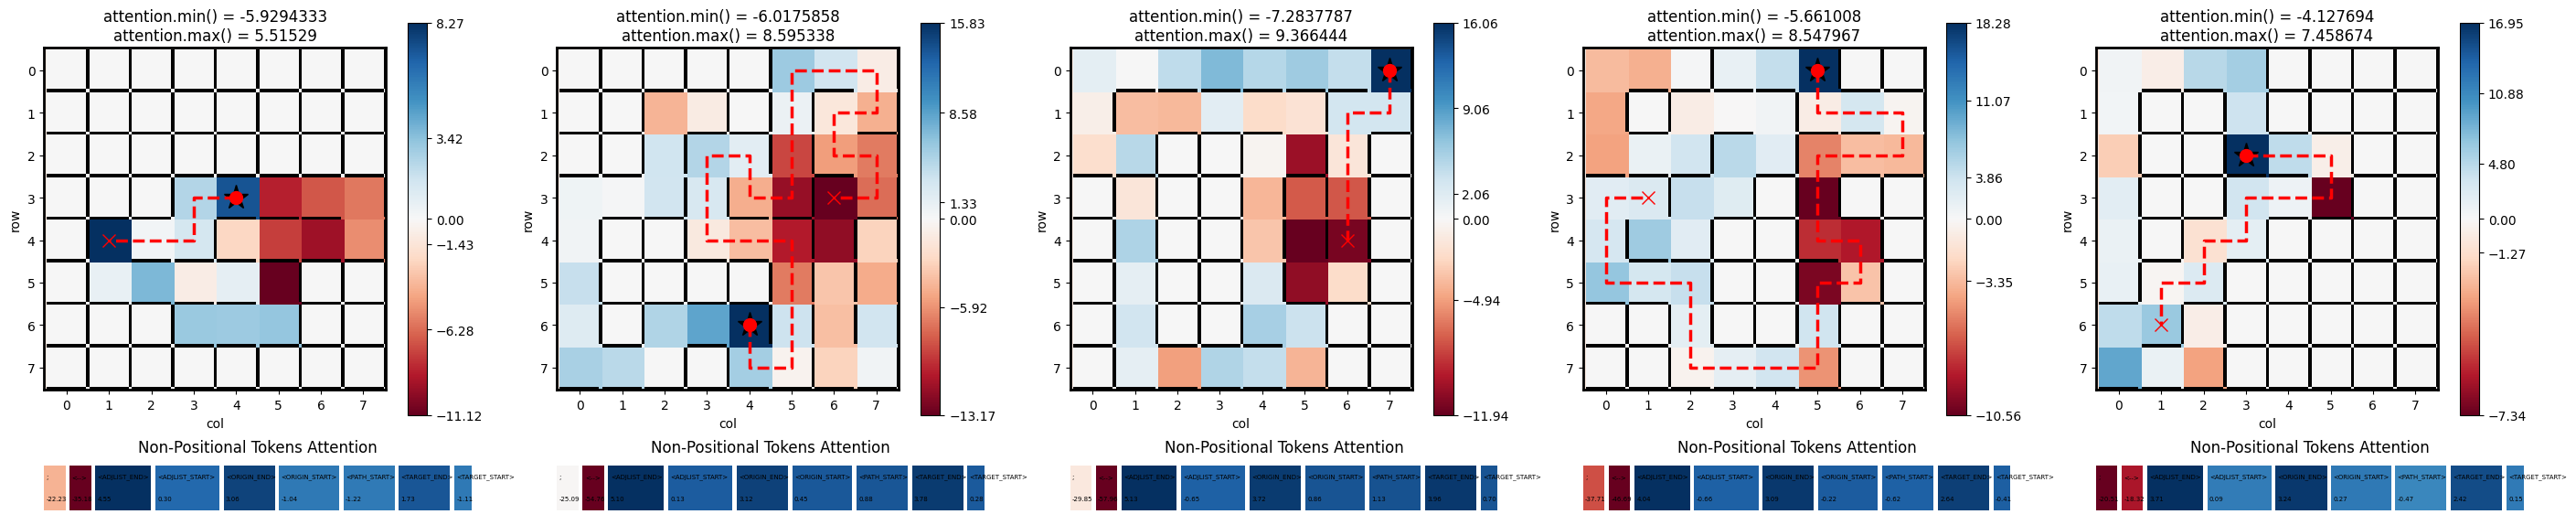

In [16]:
# let's try to plot the values of the attention heads for the top and bottom n contributing heads
# (layer, head, value)
top_heads: int = 5
important_heads: list[tuple[int, int, float]] = sorted(
    [
        (i, j, DLA_DATA[i, j])
        for i in range(DLA_DATA.shape[0])
        for j in range(DLA_DATA.shape[1])
	],
    key=lambda x: abs(x[2]),
    reverse=True,
)[:top_heads]
print(f"{important_heads = }")

# plot the attention heads
print(f"{CACHE.keys() = }")
important_heads_scores = {
    f"layer_{i}.head_{j}": (
        c,
        CACHE[f'blocks.{i}.attn.hook_attn_scores'][:, j, :, :].numpy(),
    )
    for i, j, c in important_heads
}

print("="*80)

attn_final_tok_output = plot_attention_final_token(
    important_heads_scores=important_heads_scores,
    prompts=DATASET_PROMPTS,
    targets=DATASET_TARGETS,
    mazes=DATASET,
    tokenizer=TOKENIZER,
    n_mazes=5,
    last_n_tokens=20,
    exponentiate_scores=False,
    plot_colored_tokens=True,
    plot_scores=True,
    maze_colormap_center=0.0,
    show_all=True,
)


# TODO: total attention on coords within path as opposed to not in path?